In [60]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os


In [61]:
# Define dataset path
data_dir = "./data"

# Load dataset
batch_size = 32
img_size = (160, 160)


# The Data

The dataset used in this project is available at the following link:  
[Microsoft DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M)

> The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.  
> The DigiFace-1M dataset can be used for non-commercial research.  
>   
> The dataset contains:  
>   
> - 720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.  
> - 500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

From the dataset, I am using 32 folders, each representing a class of 3D-rendered synthetic people. Each folder includes 71 photos captured from different angles and lighting conditions.

## Batch Size

Batch size refers to the number of images processed by the model at once. In this case, 32 images are passed through the neural network per batch.

- **Larger Batch Size**: Speeds up training but requires more memory.
- **Smaller Batch Size**: Provides better generalization but slows down training.

## Image Size

Images are resized to 160x160 pixels before being fed into the neural network. This ensures that all input images have the same dimensions for consistency.

In [62]:

train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size)

val_dataset = image_dataset_from_directory(data_dir,
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    image_size=img_size)

# Get class names
class_names = train_dataset.class_names
print("Class names:", class_names)

# Ensure the number of classes matches the dataset
num_classes = len(class_names)
print("Number of classes:", num_classes)


Found 7216 files belonging to 101 classes.
Found 7216 files belonging to 101 classes.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'me']
Number of classes: 101


In [ ]:
# Normalize images and apply data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


In [64]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights="imagenet")

base_model.trainable = False  # Freeze the base model


In [65]:

# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


In [66]:

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,434,981 (9.29 MB)

 Trainable params: 176,997 (691.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [67]:
epochs = 15

history = model.fit(train_dataset,validation_data=val_dataset, epochs=epochs)


Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.0231 - loss: 4.6277 - val_accuracy: 0.0184 - val_loss: 4.7590
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.1040 - loss: 4.0206 - val_accuracy: 0.0212 - val_loss: 5.0697
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.1827 - loss: 3.4167 - val_accuracy: 0.0252 - val_loss: 5.6698
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.2585 - loss: 3.0084 - val_accuracy: 0.0262 - val_loss: 6.0934
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.2999 - loss: 2.7115 - val_accuracy: 0.0269 - val_loss: 6.2079
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.3546 - loss: 2.4802 - val_accuracy: 0.0342 - val_loss: 6.4588
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.3872 - loss: 2.2692 - val_accuracy: 0.0371 - val_loss: 6.6994
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.4329 - loss: 2

In [68]:
# Evaluating the model

test_loss, test_acc = model.evaluate(train_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8740 - loss: 0.7162
Test Accuracy: 0.8839


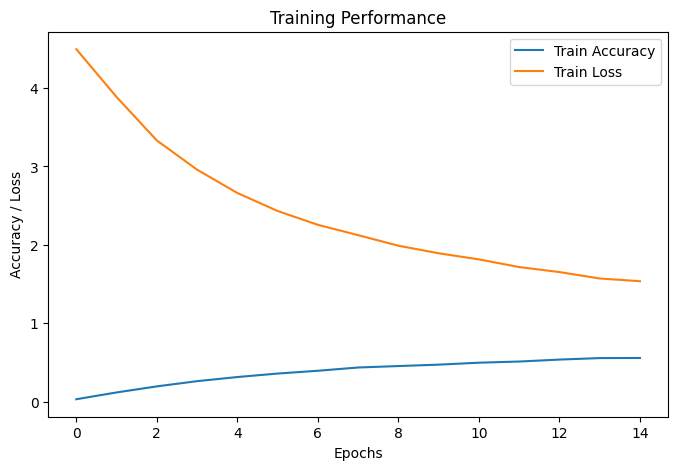

In [69]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.title('Training Performance')
plt.show()


In [78]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomShear(0.2),
    layers.Rescaling(1./255)  # Normalize again after augmentation
])



In [79]:
val_split = 0.2  # 20% for validation
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=42,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='categorical'  # Ensure categorical labels
)
val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=42,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='categorical'
)

Found 7216 files belonging to 101 classes.
Using 5773 files for training.
Found 7216 files belonging to 101 classes.
Using 1443 files for validation.


In [80]:
from sklearn.utils.class_weight import compute_class_weight

# Flatten the labels to a 1D array
labels = np.argmax(np.concatenate([y.numpy() for x, y in train_dataset]), axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(0.9219099329287768), 1: np.float64(0.9854899283031752), 2: np.float64(0.9526402640264027), 3: np.float64(0.9854899283031752), 4: np.float64(0.9072764419299073), 5: np.float64(0.9687867091793925), 6: np.float64(0.9219099329287768), 7: np.float64(1.0027792252909502), 8: np.float64(0.9526402640264027), 9: np.float64(0.9854899283031752), 10: np.float64(0.9854899283031752), 11: np.float64(1.0392439243924392), 12: np.float64(0.9854899283031752), 13: np.float64(1.0392439243924392), 14: np.float64(1.0027792252909502), 15: np.float64(0.937023210517773), 16: np.float64(0.9854899283031752), 17: np.float64(0.937023210517773), 18: np.float64(1.0584891822515585), 19: np.float64(0.8531106842027486), 20: np.float64(0.9072764419299073), 21: np.float64(0.9854899283031752), 22: np.float64(1.0027792252909502), 23: np.float64(1.0584891822515585), 24: np.float64(0.8931002475247525), 25: np.float64(1.120753251795768), 26: np.float64(0.9219099329287768), 27: np.float64(1.07846067

In [81]:
base_model.trainable = True  # Unfreeze the base model for fine-tuning
for layer in base_model.layers[:-60]:  # Freeze the initial layers
    layer.trainable = False



In [82]:
# Adding Batch Normalization and Gradient Clipping

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  # Normalize activations
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [83]:

# Recompiling the model with a lower learning rate

optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:

# Adding Callbacks

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.5,
                                                 patience=3,
                                                 min_lr=1e-6)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5,
                                               restore_best_weights=True)


model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [lr_scheduler, early_stopping, model_checkpoint]



In [ ]:
epochs = 15
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks)



Epoch 1/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2579 - loss: 3.5143

In [ ]:
# Evaluating the model

test_loss, test_acc = model.evaluate(train_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.0122 - loss: 6.8502
Test Accuracy: 0.0107


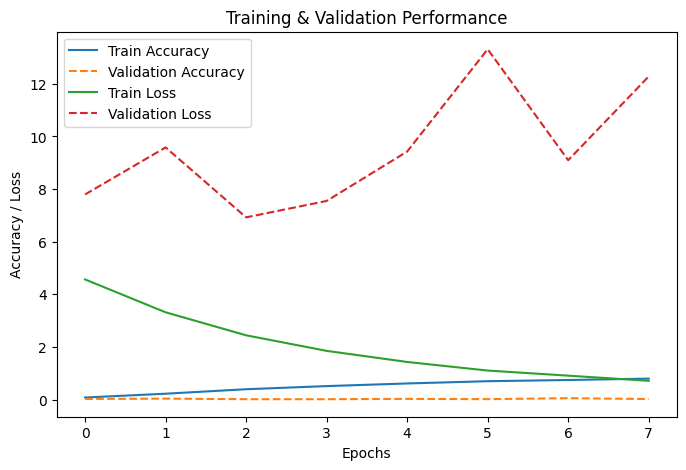

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.title('Training & Validation Performance')
plt.show()

In [ ]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions and true labels
y_pred = np.argmax(model.predict(val_dataset), axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in val_dataset])

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# Plot Learning Rate Changes
lrs = [lr_scheduler.model.optimizer.lr.numpy() for epoch in range(epochs)]
plt.figure(figsize=(8, 5))
plt.plot(lrs, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Scheduler')
plt.legend()
plt.show()


In [ ]:
# save model
model.save("model.h5")
print("Model saved to disk.")

Model saved to disk.
